# Data loading for HTR

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import opendatasets as od
import sys
import matplotlib as plt
# loss = tf.keras.losses.CTC(
#     reduction='sum_over_batch_size', name='ctc'
# )

# Path to the downloaded dataset
#od.download('https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database')
dataset_path = './iam-handwriting-word-database'
words_transcription_file = os.path.join(dataset_path, 'words_new.txt')
words_images_base_path = os.path.join(dataset_path, 'iam_words')

# Load transcriptions
transcriptions = {}
with open(words_transcription_file, 'r') as f:
    for line in f:
        if line.strip() and not line.strip().startswith('#'):
            parts = line.strip().split(' ')
            image_id = parts[0]
            transcription = parts[-1]
            transcriptions[image_id] = transcription
            #image_id, transcription = parts
           # transcriptions[image_id] = transcription.replace('|', ' ')

print(f"Loaded {len(transcriptions)} transcriptions.")

# Prepare image paths and labels
image_paths = []
labels = []

print("Gathering image paths and labels...")
count = 0
max_examples = 10

for image_id, transcription in transcriptions.items():
    parts = image_id.split('-')
    if len(parts) >= 4:
        writer_id = parts[0]
        writer_page_num = parts[0] + '-' + parts[1]
        image_filename = f"{image_id}.png"

        relative_path_corrected = os.path.join('words', writer_id, writer_page_num, image_filename)
        full_image_path = os.path.join(words_images_base_path, relative_path_corrected)

        if count < max_examples:
            # print(f"Checking path for image ID {image_id}: {full_image_path}")
            # print(f"Does path exist? {os.path.exists(full_image_path)}")
            print(f"transcription: {transcription}")
            print(f"image path: {full_image_path}")
            
            count += 1

        if os.path.exists(full_image_path):
            image_paths.append(full_image_path)
            
            labels.append(transcription)
 

print(f"Found {len(image_paths)} images with corresponding transcriptions.")
all_chars = sorted(list(set(''.join(labels))))
print("vocab: {all_chars}")
valid_image_paths = []
valid_labels = []
#check if files are empty or path leads to nothing
for path, label in zip(image_paths, labels):
    if not os.path.exists(path):
        print(f"Missing file: {path}")
        continue
    if os.path.getsize(path) == 0:
        print(f"Empty file (0 bytes): {path}")
        continue
    try:
        img_raw = tf.io.read_file(path)
        img = tf.io.decode_png(img_raw, channels=1)
        valid_image_paths.append(path)
        valid_labels.append(label)
    except Exception as e:
        print(f"Error loading {path}: {e}")

print(f"Valid files after cleanup: {len(valid_image_paths)}")

#only use paths that are confirmed
image_paths = valid_image_paths
labels = valid_labels


#create vocabulary: maps numbers to labels, and vice versa
all_chars = sorted(list(set(''.join(labels))))
char_to_num = tf.keras.layers.StringLookup(vocabulary=all_chars, mask_token=None, oov_token="[UNK]")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, oov_token="[UNK]", invert=True)

print(f"Vocabulary size: {len(all_chars)}")
print(f"Vocabulary: {all_chars}")


#preprocessing function
def process_data(image_path, label):
    image_path = tf.cast(image_path, tf.string)
    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)

    img_height = 64
    img_width = 256
    height, width = tf.shape(img)[0], tf.shape(img)[1]
    scale = tf.cast(img_height, tf.float32) / tf.cast(height, tf.float32)
    img_width_new = tf.cast(tf.cast(width, tf.float32) * scale, tf.int32)
    img_width_new = tf.minimum(img_width_new, img_width)

    img = tf.image.resize(img, [img_height, img_width_new])
    img = tf.image.pad_to_bounding_box(img, 0, 0, img_height, img_width)

    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return img, label


train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)
#confirming labels and paths look proper
for i in range(10):
    print(f"Label {i}: {train_labels[i]}")
train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_image_paths, val_labels))

#sets up optimal parallel processing
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process_data, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_data, num_parallel_calls=AUTOTUNE)

print("\nData preprocessing complete")
print(f"Training dataset size: {tf.data.experimental.cardinality(train_ds).numpy()} batches")
print(f"Validation dataset size: {tf.data.experimental.cardinality(val_ds).numpy()} batches")

# Label padding setup
all_labels = train_labels + val_labels
max_label_len = max(len(label) for label in all_labels)
print(f"Max label length across dataset: {max_label_len}")


def prepare_for_ctc(img, label):
    input_len = tf.shape(img)[1] // 4  # Downsampling by factor 4
    label_len = tf.shape(label)[0]
    input_len = tf.expand_dims(input_len, axis=0)
    label_len = tf.expand_dims(label_len, axis=0)
    return img, label, input_len, label_len

#ctc_prep_map for model input/output formatting
def ctc_prep_map(img, label, input_len, label_len):
    return (
        {
            "image": img,
            "label": label,
            "input_length": input_len,
            "label_length": label_len
        },
        tf.zeros([1])  # Dummy output for loss
    )

# Define padded shapes
padded_shapes = (
    [64, 256, 1],     # image
    [max_label_len],  # label
    [1],              # input_length
    [1]               # label_length
)

def has_valid_label(img, label):
    # Example: check label length > 0
    return tf.greater(tf.shape(label)[0], 0)

train_ds = train_ds \
    .filter(has_valid_label) \
    .map(prepare_for_ctc, num_parallel_calls=AUTOTUNE) \
    .padded_batch(32, padded_shapes=padded_shapes, drop_remainder=True) \
    .map(ctc_prep_map, num_parallel_calls=AUTOTUNE) \
    .cache().prefetch(AUTOTUNE)

val_ds = val_ds \
    .filter(has_valid_label) \
    .map(prepare_for_ctc, num_parallel_calls=AUTOTUNE) \
    .padded_batch(32, padded_shapes=padded_shapes, drop_remainder=True) \
    .map(ctc_prep_map, num_parallel_calls=AUTOTUNE) \
    .cache().prefetch(AUTOTUNE)



Loaded 44564 transcriptions.
Gathering image paths and labels...
transcription: A
image path: ./iam-handwriting-word-database\iam_words\words\a01\a01-000u\a01-000u-00-00.png
transcription: MOVE
image path: ./iam-handwriting-word-database\iam_words\words\a01\a01-000u\a01-000u-00-01.png
transcription: to
image path: ./iam-handwriting-word-database\iam_words\words\a01\a01-000u\a01-000u-00-02.png
transcription: stop
image path: ./iam-handwriting-word-database\iam_words\words\a01\a01-000u\a01-000u-00-03.png
transcription: Mr.
image path: ./iam-handwriting-word-database\iam_words\words\a01\a01-000u\a01-000u-00-04.png
transcription: Gaitskell
image path: ./iam-handwriting-word-database\iam_words\words\a01\a01-000u\a01-000u-00-05.png
transcription: from
image path: ./iam-handwriting-word-database\iam_words\words\a01\a01-000u\a01-000u-00-06.png
transcription: nominating
image path: ./iam-handwriting-word-database\iam_words\words\a01\a01-000u\a01-000u-01-00.png
transcription: any
image path: ./i

# HTR Model architecture and training


In [3]:
#Model

import tensorflow as tf
import numpy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, Dense, GRU, Bidirectional, Input, Lambda, SimpleRNN, Dropout, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam


img_height = 64
img_width = 256
num_classes = len(all_chars) + 1  # +1 for the CTC blank token

# Define the input shape (grayscale images)
input_shape = (img_height, img_width, 1)

# Input layers named to match your dataset keys exactly
input_img = Input(shape=input_shape, name='image')  # Matches 'image' key in dataset
labels = Input(name='label', shape=[None], dtype='int32')  # Changed dtype to int32
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

# --- CNN Feature Extraction ---
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

#Alexander's CNN
# x = Conv2D(filters=16, kernel_size=(3,3), activation='relu')(input_img)
# x = MaxPooling2D()(x)
# x = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
# x = MaxPooling2D()(x)
# x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x)
# x = MaxPooling2D()(x)
# x = Conv2D(filters=128, kernel_size=(3,3), activation='relu')(x)

# Calculate shape after conv and pooling layers
#adjust this if architecture changes
cnn_output_height = img_height // 4  # 2 max pools with stride 2 → 64/4=16
cnn_output_width = img_width // 4    # 256/4=64
cnn_output_filters = 32

feature_dimension = cnn_output_height * cnn_output_filters 

# Reshape CNN output for RNN layers
x = Reshape(target_shape=(cnn_output_width, feature_dimension), name='reshape')(x)
#ValueError: The total size of the tensor must be unchanged. Received: input_shape=(4, 28, 128), target_shape=(64, 512)Cell Execution Error

#RNN
gru_units = 64
x = Bidirectional(GRU(gru_units, return_sequences=True, kernel_initializer='he_normal'), name='gru1')(x)
x = Bidirectional(GRU(gru_units, return_sequences=True, kernel_initializer='he_normal'), name='gru2')(x)
# x = SimpleRNN(64, return_sequences=True, activation='relu', dropout=0.3)(x)
# x = LSTM(128, dropout=0.4, return_sequences=True, recurrent_dropout=0.4)(x)
# x = Dense(128, activation='relu')(x)
# x = Dense(64, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(32, activation='relu')(x)
# x = Dropout(0.4)(x)

# --- Output Layer ---
output = Dense(num_classes, activation='softmax', name='dense_output')(x)

# Clip labels so that no label exceeds num_classes-2 (max valid index)
# This is a safety step; ideally fix this in preprocessing
clipped_labels = Lambda(lambda y: tf.clip_by_value(y, 0, num_classes - 2), name='clip_labels')(labels)

# --- CTC Loss Function ---
def ctc_lambda_func(args):
    y_pred, y_true, input_len, label_len = args
    return K.ctc_batch_cost(y_true, y_pred, input_len, label_len)

# --- Define the Model for Training with CTC Loss ---
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
    [output, clipped_labels, input_length, label_length]
)

training_model = Model(
    inputs=[input_img, labels, input_length, label_length],
    outputs=loss_out
)

# Compile training model with dummy lambda loss (loss calculated inside Lambda layer)
adam_optimizer = Adam(learning_rate=0.001)
training_model.compile(optimizer=adam_optimizer, loss={'ctc': lambda y_true, y_pred: y_pred}, metrics=['accuracy'])


train_steps = tf.data.experimental.cardinality(train_ds).numpy()
val_steps = tf.data.experimental.cardinality(val_ds).numpy()

history = training_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    steps_per_epoch=200,
    validation_steps=200,
)

# Print the keys in history
print("History keys:", history.history.keys())

# loss, accuracy = model.evaluate(val_ds)
# print(f"Accuracy: {accuracy} \t Loss: {loss}")

plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title(f'{model} Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Epoch 1/30

200/200 ━━━━━━━━━━━━━━━━━━━━ 53s 226ms/step - accuracy: 0.0000e+00 - loss: 42.0738 - val_accuracy: 0.0000e+00 - val_loss: 14.9182
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 44s 218ms/step - accuracy: 0.0000e+00 - loss: 14.6525 - val_accuracy: 0.0000e+00 - val_loss: 14.3929
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 43s 216ms/step - accuracy: 0.0000e+00 - loss: 14.1666 - val_accuracy: 0.0000e+00 - val_loss: 14.0998
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 205ms/step - accuracy: 0.0000e+00 - loss: 14.2137 - val_accuracy: 0.0000e+00 - val_loss: 13.7590
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - accuracy: 0.0000e+00 - loss: 13.7114 - val_accuracy: 0.0000e+00 - val_loss: 13.4785
Epoch 6/30
114/200 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.0000e+00 - loss: 13.3201

C:\Users\ahirs\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 142ms/step - accuracy: 0.0000e+00 - loss: 13.2687 - val_accuracy: 0.0000e+00 - val_loss: 13.3570
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 44s 221ms/step - accuracy: 1.7762e-04 - loss: 13.3286 - val_accuracy: 0.0094 - val_loss: 13.0836
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 224ms/step - accuracy: 0.0100 - loss: 12.9725 - val_accuracy: 0.0356 - val_loss: 12.8864
Epoch 9/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 225ms/step - accuracy: 0.0359 - loss: 12.6394 - val_accuracy: 0.0372 - val_loss: 12.6698
Epoch 10/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 225ms/step - accuracy: 0.0456 - loss: 12.7887 - val_accuracy: 0.0578 - val_loss: 12.4379
Epoch 11/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 43s 213ms/step - accuracy: 0.0570 - loss: 12.4525 - val_accuracy: 0.0597 - val_loss: 12.2968
Epoch 12/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 152ms/step - accuracy: 0.0566 - loss: 12.0965 - val_accuracy: 0.0473 - val_loss: 12.3207
Epoch 13/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 224ms/step - accurac

TypeError: 'module' object is not callable

In [ ]:

def decode_ctc_predictions(predictions):
    decoded_texts = []
    for i in range(len(predictions)):
        pred = predictions[i]
 
        input_len = np.array([pred.shape[0]])
        decoded_sequences = tf.keras.backend.ctc_decode(
            np.expand_dims(pred, 0),
            input_len,
            greedy=True
        )[0][0]
        
        indices = decoded_sequences.numpy().flatten()
        text_chars = []
        
        for idx in indices:
            if idx > 0:  # Skip blank tokens
                char = num_to_char([idx])  # Pass as list
                if hasattr(char, 'numpy'):
                    char_bytes = char.numpy()
                    if isinstance(char_bytes, np.ndarray):
                        char_bytes = char_bytes[0]  # Get first element if array
                    
                    # Convert bytes to string
                    if isinstance(char_bytes, bytes):
                        char = char_bytes.decode('utf-8')
                    else:
                        char = str(char_bytes)

                text_chars.append(char)
        
        # Join the characters
        text = ''.join([str(char) for char in text_chars])
        decoded_texts.append(text)
    
    return decoded_texts

# val_images = extract_images(val_ds)
val_images = val_ds.map(lambda inputs, outputs: inputs["image"])
prediction_model = Model(
    inputs=input_img,
    outputs=output
)
prediction_model.set_weights(training_model.get_weights()) #copy trained model to prediction model
prediction = prediction_model.predict(val_images)
predicted_words = decode_ctc_predictions(prediction)
#predicted_words = prediction.argmax(axis=1)




278/278 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step


In [ ]:
for label, predicted_word in zip(val_labels, predicted_words):
    print(f"{predicted_word==label} \t predicted \"{label}\" - as \"{predicted_word}\"")

predicted_sentences = []
sentence = []
punctuation = [',',':',';','?','.','!','(',')', '[',']','{','}']
for i in range(len(predicted_words)):
    #if word is ending puncuation, add sentence to list and clear it
    word = predicted_words[i]
    if(word in ['?','.','!']):
        sentence.append(word)
        sentence = ''.join(sentence) #convert list to string sentence
        predicted_sentences.append(sentence)
        sentence = []
        continue
    #otherwise add it to list with a space
    sentence.append(word)
    try:
        #only add a space if the next word is not punctuation
        if(predicted_words[i+1] not in punctuation):
            sentence.append(" ")
    except Exception:
        #runs if i+1 causes index out of bounds. Do nothing
        pass

if sentence.count != 0: #last predicted sentence did not end with proper punctuation, add it to list of sentences
    sentence = ''.join(sentence)
    predicted_sentences.append(sentence)

for s in predicted_sentences:
    print(s)
with open("HTR_output.txt", "w") as text_file:
    for s in predicted_sentences:
        text_file.write(s)
        text_file.write("\n")

# RNN

Training samples: 6840
Validation samples: 1711
training shape (6840,)
val shape (1711,)
Epoch 1/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.6916 - loss: 0.6368 - val_accuracy: 0.7032 - val_loss: 0.6087
Epoch 2/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6996 - loss: 0.6218 - val_accuracy: 0.7032 - val_loss: 0.6114
Epoch 3/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.6903 - loss: 0.6268 - val_accuracy: 0.7032 - val_loss: 0.6082
Epoch 4/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.7017 - loss: 0.6153 - val_accuracy: 0.7032 - val_loss: 0.6087
Epoch 5/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.7052 - loss: 0.6093 - val_accuracy: 0.7032 - val_loss: 0.6111
Epoch 6/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.7021 - loss: 0.6116 - val_accuracy: 0.7032 - val_loss: 0.6087
Epoch 7/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.7009 - loss: 0.6114 - val_accuracy: 0.7032 - val_loss: 0.6112
Epoch 8

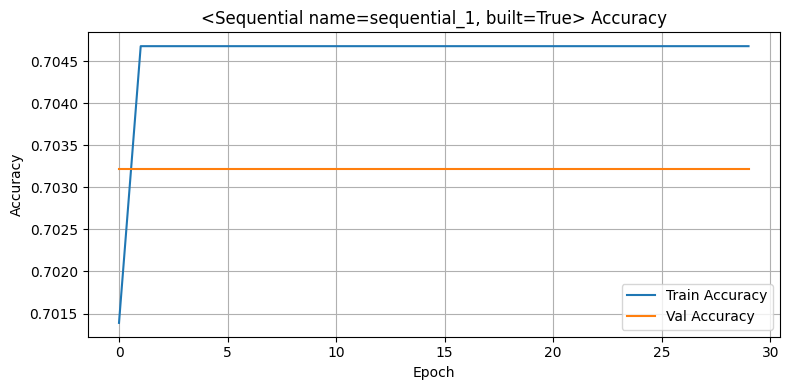

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7000 - loss: 0.6109


In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, SimpleRNN, Input, Embedding, Flatten, LSTM
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

df = pd.read_csv('rnn_data.tsv', sep='\t', header=None)

#get column indices 1 and 3 for relevant data (1=label, 3=data)
labels = df.iloc[:, 1]
texts = df.iloc[:, 3]

X_train, X_val, y_train, y_val = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

#shape = 6840 for training, 1711 for validation
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"training shape {X_train.shape}")
print(f"val shape {X_val.shape}")

#map words to integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
x_train_tokenized = tokenizer.texts_to_sequences(X_train)
x_train_pad = pad_sequences(x_train_tokenized, padding='post')
x_train_embedded = len(tokenizer.word_index) + 1
max_len = x_train_pad.shape[1]

model = Sequential([
    # Embedding(input_dim=x_train_embedded, output_dim=64),
    # LSTM(128, dropout=0.4, recurrent_dropout=0.4),  # Remove SimpleRNN layer
    # Dense(64, activation='relu'),
    # Dropout(0.8),
    # Dense(1, activation='sigmoid')
    
    Embedding(input_dim=x_train_embedded, output_dim=64),
    SimpleRNN(32, return_sequences=True, activation='relu', dropout=0.3),
    SimpleRNN(64, return_sequences=True, activation='relu', dropout=0.3),
    LSTM(128, dropout=0.4, recurrent_dropout=0.4),  # Increased dropout
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5),  # Increased dropout
    Dense(32, activation='relu'),
    Dropout(0.4),  # Add dropout here too
    Dense(1, activation='sigmoid')

])

model.compile(optimizer=Adam(learning_rate=0.003), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train_pad, y_train, validation_split=0.2,epochs=30, batch_size=32)


#tokenize and padd evaluation data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_val)
x_val_tokenized = tokenizer.texts_to_sequences(X_val)
x_val_pad = pad_sequences(x_val_tokenized, padding='post')
loss, accuracy = model.evaluate(x_val_pad, y_val)
print(f"Accuracy: {accuracy} \t Loss: {loss}")

plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title(f'{model} Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_val)
x_val_tokenized = tokenizer.texts_to_sequences(X_val)
x_val_pad = pad_sequences(x_val_tokenized, padding='post')
loss, accuracy = model.evaluate(x_val_pad, y_val)

In [45]:
tokenizer.fit_on_texts(predicted_sentences)
prediction_tokenized = tokenizer.texts_to_sequences(predicted_sentences)
prediction_pad = pad_sequences(prediction_tokenized, padding='post')
rnn_prediction = model.predict(prediction_pad)

validation_predictions = model.predict(x_val_pad)
for predicted_word, assurity in zip(predicted_sentences, rnn_prediction):
    print(f"{assurity}% that \"{predicted_word}\" is correct")



13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
[0.6984199]% that "detien ant wit mod and for the." is correct
[0.6984199]% that "ie ol ae seed and) the - poe the, a thny foed poe woted coed a moed: boe ae dited Boe tot of ae the fr the oy flels fom coniny of aot sin te the of wot ", peped foe oiy ad of wid seeie wih and  for the " sah, The tht thr." is correct
[0.6984199]% that "oy The pod a fot the, foges fogt, s montins and wid oy fie the oy ligt conies and." is correct
[0.6984199]% that "mot pos hd and coned i ail wilh of boe foe iotend, deed bod wol tomes wil ae pos doed the toe ae " Pees ", te ot wit petiey mlgt is and Tae to cetiny wae anh togny ar tr " pot io oe ae." is correct
[0.6984199]% that "fot the hd io moed the." is correct
[0.6984199]% that "to teine woed a melily ae the the, for ae deed fs pit Beaeh dotiny the for is." is correct
[0.6984199]% that ", moly dae pegily wilh fod, thh, motien wod Boe woies teten doed ot the wan cee pties met